In [1]:
# reference: https://www.kaggle.com/kernels/notebooks/new?forkParentScriptVersionId=8421466&userName=fhiroki
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

/Users/hiroki/.pyenv/versions/3.5.1/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [123]:
new_transactions = pd.read_csv('input/original/small_new_transactions.csv',
                               index_col=0,
                               parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/original/small_hist_transactions.csv',
                                      index_col=0,
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

new_transactions = binarize(new_transactions)
historical_transactions = binarize(historical_transactions)

In [124]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_b3b9eae477,69,0,1,B,434,M_ID_bf7836070a,2,-0.526920,2018-04-25 13:57:58,1.0,9,32
1,1,C_ID_ab53c3b7b7,143,0,1,B,683,M_ID_36a0bc4c75,1,-0.743151,2017-07-19 15:58:48,5.0,5,34
2,1,C_ID_31839e7896,69,0,0,A,683,M_ID_2637773dd2,2,-0.727584,2018-04-07 19:32:57,1.0,9,34
3,1,C_ID_e5741986a9,69,0,0,A,80,M_ID_42d134923f,1,-0.716855,2018-02-02 16:47:14,1.0,9,37
4,1,C_ID_ab5e006d01,69,0,1,B,278,M_ID_697362ccad,2,-0.636944,2018-04-22 20:42:36,1.0,9,37


In [125]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/original/train.csv')
test = read_data('input/original/test.csv')

target = train['target']
del train['target']

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [ ]:
print(train.shape, test.shape)
print(new_transactions.shape, historical_transactions.shape)

In [ ]:
train.head()

In [ ]:
new_transactions.head()

In [ ]:
historical_transactions.head()

In [ ]:
historical_transactions['authorized_flag'].value_counts() / historical_transactions.shape[0] * 100

In [126]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [127]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [128]:
historical_transactions['year'] = historical_transactions['purchase_date'].dt.year
historical_transactions['weekofyear'] = historical_transactions['purchase_date'].dt.weekofyear
historical_transactions['month'] = historical_transactions['purchase_date'].dt.month
historical_transactions['dayofweek'] = historical_transactions['purchase_date'].dt.dayofweek
historical_transactions['weekend'] = (historical_transactions.purchase_date.dt.weekday >=5).astype(int)
historical_transactions['hour'] = historical_transactions['purchase_date'].dt.hour

new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour

In [129]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff,year,weekofyear,month,dayofweek,weekend,hour
0,1,C_ID_5e54c0fb92,158,0,0,A,705,M_ID_c1a7024db1,-13,-0.726592,2017-01-12 15:34:29,1.0,15,33,12,2017,2,1,3,0,15
1,1,C_ID_aa6b091251,-1,0,0,A,367,M_ID_bf5779026a,-5,-0.668545,2017-09-15 13:40:24,NaN,-1,16,12,2017,37,9,4,0,13
2,1,C_ID_334ecb5825,-1,1,1,B,661,M_ID_fc7d7969c3,-2,-0.712497,2017-12-10 14:59:02,NaN,-1,8,12,2017,49,12,6,1,14
3,1,C_ID_40b2f47218,143,0,1,B,222,M_ID_5768173411,-6,-0.718703,2017-08-01 13:38:13,5.0,5,21,12,2017,31,8,1,0,13
4,1,C_ID_38ad03cdcd,271,0,1,B,307,M_ID_e36510761b,-4,-0.701828,2017-10-30 00:00:00,1.0,9,19,11,2017,44,10,0,0,0


In [130]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 26.94 Mb (52.4% reduction)
Mem. usage decreased to 16.23 Mb (55.5% reduction)


In [52]:
auth_mean.head()

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.000000
1,C_ID_000183fdda,1.000000
2,C_ID_00024e244b,1.000000
3,C_ID_0002ba3c2e,0.333333
4,C_ID_00032df08f,1.000000


In [131]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [132]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9

    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean', 'nunique'],
    'category_2_2.0': ['mean', 'nunique'],
    'category_2_3.0': ['mean', 'nunique'],
    'category_2_4.0': ['mean', 'nunique'],
    'category_2_5.0': ['mean', 'nunique'],
    'category_3_A': ['mean', 'nunique'],
    'category_3_B': ['mean', 'nunique'],
    'category_3_C': ['mean', 'nunique'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [133]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_city_id_nunique,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_4.0_mean,hist_category_2_4.0_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_month_diff_mean,hist_category_2_1.0_mean,hist_category_2_1.0_nunique,hist_category_2_2.0_mean,hist_category_2_2.0_nunique,hist_category_3_A_mean,hist_category_3_A_nunique,hist_state_id_nunique,hist_category_2_3.0_mean,hist_category_2_3.0_nunique,hist_subsector_id_nunique,hist_category_3_C_mean,hist_category_3_C_nunique,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_category_2_5.0_mean,hist_category_2_5.0_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_3_B_mean,hist_category_3_B_nunique
0,C_ID_00007093c1,1,1,-4.0,-4,-4,NaN,1,1.0,1,1,NaN,0.0,1,10.0,10,10,NaN,1,1,-0.649414,-0.649414,-0.649414,-0.649414,NaN,12.0,0.0,1,0.0,1,0.0,1,1,1.0,1,1,0.0,1,0.0,1.508799e+09,1.508799e+09,0.0,1,0,0.0,1.0,1
1,C_ID_0002ba3c2e,2,1,-1.5,0,-3,2.12132,0,0.0,0,0,0.0,0.0,1,8.5,10,7,2.12132,2,2,-1.103516,-0.551758,-0.506836,-0.596680,0.063538,15.5,0.0,1,1.0,1,1.0,1,1,0.0,1,2,0.0,1,8095679.0,1.501181e+09,1.509277e+09,0.0,1,0,0.0,0.0,1
2,C_ID_00042d509c,1,1,-1.0,-1,-1,NaN,1,1.0,1,1,NaN,0.0,1,11.0,11,11,NaN,1,1,-0.720703,-0.720703,-0.720703,-0.720703,NaN,14.0,0.0,1,0.0,1,0.0,1,1,0.0,1,1,0.0,1,0.0,1.511061e+09,1.511061e+09,0.0,1,1,1.0,1.0,1
3,C_ID_000aa2220e,1,1,-3.0,-3,-3,NaN,1,1.0,1,1,NaN,0.0,1,11.0,11,11,NaN,1,1,-0.044067,-0.044067,-0.044067,-0.044067,NaN,12.0,1.0,1,0.0,1,0.0,1,1,0.0,1,1,0.0,1,0.0,1.509740e+09,1.509740e+09,0.0,1,0,0.0,1.0,1
4,C_ID_000b24f797,1,1,-7.0,-7,-7,NaN,1,1.0,1,1,NaN,0.0,1,7.0,7,7,NaN,1,1,-0.731934,-0.731934,-0.731934,-0.731934,NaN,12.0,0.0,1,0.0,1,0.0,1,1,1.0,1,1,0.0,1,0.0,1.500488e+09,1.500488e+09,0.0,1,0,0.0,1.0,1


In [134]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_city_id_nunique,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_category_2_4.0_mean,auth_category_2_4.0_nunique,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_month_diff_mean,auth_category_2_1.0_mean,auth_category_2_1.0_nunique,auth_category_2_2.0_mean,auth_category_2_2.0_nunique,auth_category_3_A_mean,auth_category_3_A_nunique,auth_state_id_nunique,auth_category_2_3.0_mean,auth_category_2_3.0_nunique,auth_subsector_id_nunique,auth_category_3_C_mean,auth_category_3_C_nunique,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_category_2_5.0_mean,auth_category_2_5.0_nunique,auth_category_1_sum,auth_category_1_mean,auth_category_3_B_mean,auth_category_3_B_nunique
0,C_ID_000183fdda,1,1,-4.000000,-4,-4,NaN,2,2.0,2,2,NaN,0.0,1,10.000000,10,10,NaN,1,1,-0.612305,-0.612305,-0.612305,-0.612305,NaN,12.0,0.000000,1,0.0,1,0.0,1,1,1.0,1,1,1.0,1,0.0,1.508599e+09,1.508599e+09,0.0,1,0,0.000000,0.0,1
1,C_ID_00024e244b,1,1,-5.000000,-5,-5,NaN,0,0.0,0,0,NaN,0.0,1,9.000000,9,9,NaN,1,1,-0.734863,-0.734863,-0.734863,-0.734863,NaN,12.0,0.000000,1,0.0,1,1.0,1,1,1.0,1,1,0.0,1,0.0,1.506545e+09,1.506545e+09,0.0,1,0,0.000000,0.0,1
2,C_ID_0002ba3c2e,1,1,-2.000000,-2,-2,NaN,0,0.0,0,0,NaN,0.0,1,8.000000,8,8,NaN,1,1,-0.705566,-0.705566,-0.705566,-0.705566,NaN,16.0,1.000000,1,0.0,1,1.0,1,1,0.0,1,1,0.0,1,0.0,1.502443e+09,1.502443e+09,0.0,1,0,0.000000,0.0,1
3,C_ID_00032df08f,1,1,0.000000,0,0,NaN,1,1.0,1,1,NaN,0.0,1,11.000000,11,11,NaN,1,1,-0.664551,-0.664551,-0.664551,-0.664551,NaN,15.0,1.000000,1,0.0,1,0.0,1,1,0.0,1,1,0.0,1,0.0,1.511204e+09,1.511204e+09,0.0,1,0,0.000000,1.0,1
4,C_ID_0003be3c83,3,2,-3.666667,-3,-5,1.154701,3,1.0,1,1,0.0,0.0,1,10.333333,11,9,1.154701,3,3,-2.074219,-0.691406,-0.626465,-0.727539,0.056488,12.0,0.666667,2,0.0,1,0.0,1,2,0.0,1,3,0.0,1,3269567.0,1.506629e+09,1.509898e+09,0.0,1,1,0.333333,1.0,1


In [135]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_city_id_nunique,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_4.0_mean,new_category_2_4.0_nunique,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_merchant_id_nunique,new_merchant_category_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_month_diff_mean,new_category_2_1.0_mean,new_category_2_1.0_nunique,new_category_2_2.0_mean,new_category_2_2.0_nunique,new_category_3_A_mean,new_category_3_A_nunique,new_state_id_nunique,new_category_2_3.0_mean,new_category_2_3.0_nunique,new_subsector_id_nunique,new_category_3_C_mean,new_category_3_C_nunique,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_category_2_5.0_mean,new_category_2_5.0_nunique,new_category_1_sum,new_category_1_mean,new_category_3_B_mean,new_category_3_B_nunique
0,C_ID_0001238066,1,1,1.00,1,1,NaN,-1,-1.0,-1,-1,NaN,0.0,1,3.00,3,3,NaN,1,1,-0.151978,-0.151978,-0.151978,-0.151978,NaN,12.00,1.00,1,0.0,1,0.0,1,1,0.00,1,1,0.0,1,0.0,1.521226e+09,1.521226e+09,0.0,1,0,0.0,0.0,1
1,C_ID_0001506ef0,1,1,1.00,1,1,NaN,0,0.0,0,0,NaN,0.0,1,3.00,3,3,NaN,1,1,-0.731934,-0.731934,-0.731934,-0.731934,NaN,12.00,0.00,1,0.0,1,1.0,1,1,1.00,1,1,0.0,1,0.0,1.521710e+09,1.521710e+09,0.0,1,0,0.0,0.0,1
2,C_ID_0001793786,4,3,1.25,2,1,0.5,0,0.0,0,0,0.0,0.0,1,11.25,12,11,0.5,4,3,0.973633,0.243408,1.506836,-0.592285,0.900391,15.75,0.25,2,0.5,2,1.0,1,3,0.25,2,2,0.0,1,3980486.0,1.510761e+09,1.514741e+09,0.0,1,0,0.0,0.0,1
3,C_ID_000183fdda,1,1,2.00,2,2,NaN,-1,-1.0,-1,-1,NaN,0.0,1,4.00,4,4,NaN,1,1,-0.107666,-0.107666,-0.107666,-0.107666,NaN,11.00,0.00,1,0.0,1,0.0,1,1,1.00,1,1,0.0,1,0.0,1.525100e+09,1.525100e+09,0.0,1,0,0.0,0.0,1
4,C_ID_0003be3c83,1,1,2.00,2,2,NaN,1,1.0,1,1,NaN,0.0,1,4.00,4,4,NaN,1,1,-0.717773,-0.717773,-0.717773,-0.717773,NaN,12.00,1.00,1,0.0,1,0.0,1,1,0.00,1,1,0.0,1,0.0,1.524170e+09,1.524170e+09,0.0,1,0,0.0,1.0,1


In [136]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std
0,C_ID_000183fdda,-4.0,NaN,1.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,-0.612305,NaN,-0.612305,NaN,-0.612305,NaN,-0.612305,NaN,NaN,NaN
1,C_ID_00024e244b,-5.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,-0.734863,NaN,-0.734863,NaN,-0.734863,NaN,-0.734863,NaN,NaN,NaN
2,C_ID_0002ba3c2e,-2.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,-0.705566,NaN,-0.705566,NaN,-0.705566,NaN,-0.705566,NaN,NaN,NaN
3,C_ID_00032df08f,0.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,-0.664551,NaN,-0.664551,NaN,-0.664551,NaN,-0.664551,NaN,NaN,NaN
4,C_ID_0003be3c83,-4.0,1.414214,1.5,0.707107,1.5,0.707107,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,1.5,0.707107,-1.037109,0.581055,-0.675293,0.069031,-0.676758,0.071472,-0.673828,0.066650,0.004833,NaN
5,C_ID_0004725b87,-5.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,-0.730469,NaN,-0.730469,NaN,-0.730469,NaN,-0.730469,NaN,NaN,NaN
6,C_ID_0004888ddd,-5.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,-0.626465,NaN,-0.626465,NaN,-0.626465,NaN,-0.626465,NaN,NaN,NaN
7,C_ID_0005f16cc8,-8.0,5.656854,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.000000,-0.685547,0.018982,-0.685547,0.018982,-0.685547,0.018982,-0.685547,0.018982,NaN,NaN
8,C_ID_0006152db8,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,-0.731934,NaN,-0.731934,NaN,-0.731934,NaN,-0.731934,NaN,NaN,NaN
9,C_ID_000664aa02,-1.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,-0.545898,NaN,-0.545898,NaN,-0.545898,NaN,-0.545898,NaN,NaN,NaN


In [137]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [138]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [151]:
# reset train and test
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/original/train.csv')
test = read_data('input/original/test.csv')

target = train['target']
del train['target']

In [146]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [152]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [144]:
print(train.shape, test.shape)

(201917, 187) (123623, 187)


In [141]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_city_id_nunique,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_4.0_mean,hist_category_2_4.0_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_month_diff_mean,hist_category_2_1.0_mean,hist_category_2_1.0_nunique,hist_category_2_2.0_mean,hist_category_2_2.0_nunique,hist_category_3_A_mean,hist_category_3_A_nunique,hist_state_id_nunique,hist_category_2_3.0_mean,hist_category_2_3.0_nunique,hist_subsector_id_nunique,hist_category_3_C_mean,hist_category_3_C_nunique,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_category_2_5.0_mean,hist_category_2_5.0_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_3_B_mean,hist_category_3_B_nunique,auth_transactions_count,auth_city_id_nunique,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_category_2_4.0_mean,auth_category_2_4.0_nunique,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_month_diff_mean,auth_category_2_1.0_mean,auth_category_2_1.0_nunique,auth_category_2_2.0_mean,auth_category_2_2.0_nunique,auth_category_3_A_mean,auth_category_3_A_nunique,auth_state_id_nunique,auth_category_2_3.0_mean,auth_category_2_3.0_nunique,auth_subsector_id_nunique,auth_category_3_C_mean,auth_category_3_C_nunique,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_category_2_5.0_mean,auth_category_2_5.0_nunique,auth_category_1_sum,auth_category_1_mean,auth_category_3_B_mean,auth_category_3_B_nunique,new_transactions_count,new_city_id_nunique,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_4.0_mean,new_category_2_4.0_nunique,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_merchant_id_nunique,new_merchant_category_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_month_diff_mean,new_category_2_1.0_mean,new_category_2_1.0_nunique,new_category_2_2.0_mean,new_category_2_2.0_nunique,new_category_3_A_mean,new_category_3_A_nunique,new_state_id_nunique,new_category_2_3.0_mean,new_category_2_3.0_nunique,new_subsector_id_nunique,new_category_3_C_mean,new_category_3_C_nunique,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_category_2_5.0_mean,new_category_2_5.0_nunique,new_category_1_sum,new_category_1_mean,new_category_3_B_mean,new_category_3_B_nunique,month_lag_mean,month_lag_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_

In [48]:
target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [44]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
#          'max_depth': 9,
         'max_depth': 8,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [149]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [143]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.80008	valid_1's rmse: 3.84666
[200]	training's rmse: 3.77921	valid_1's rmse: 3.83081
[300]	training's rmse: 3.76711	valid_1's rmse: 3.8232
[400]	training's rmse: 3.75918	valid_1's rmse: 3.81944
[500]	training's rmse: 3.7537	valid_1's rmse: 3.81739
[600]	training's rmse: 3.74969	valid_1's rmse: 3.81631
[700]	training's rmse: 3.74696	valid_1's rmse: 3.81571
[800]	training's rmse: 3.74438	valid_1's rmse: 3.81516
[900]	training's rmse: 3.74217	valid_1's rmse: 3.81475
[1000]	training's rmse: 3.7402	valid_1's rmse: 3.81458
[1100]	training's rmse: 3.73825	valid_1's rmse: 3.81445
[1200]	training's rmse: 3.73642	valid_1's rmse: 3.81444
[1300]	training's rmse: 3.73438	valid_1's rmse: 3.81441
[1400]	training's rmse: 3.73261	valid_1's rmse: 3.81448
Early stopping, best iteration is:
[1238]	training's rmse: 3.73564	valid_1's rmse: 3.81436
fold n°1
Training until validation scores don't improve for 200 r

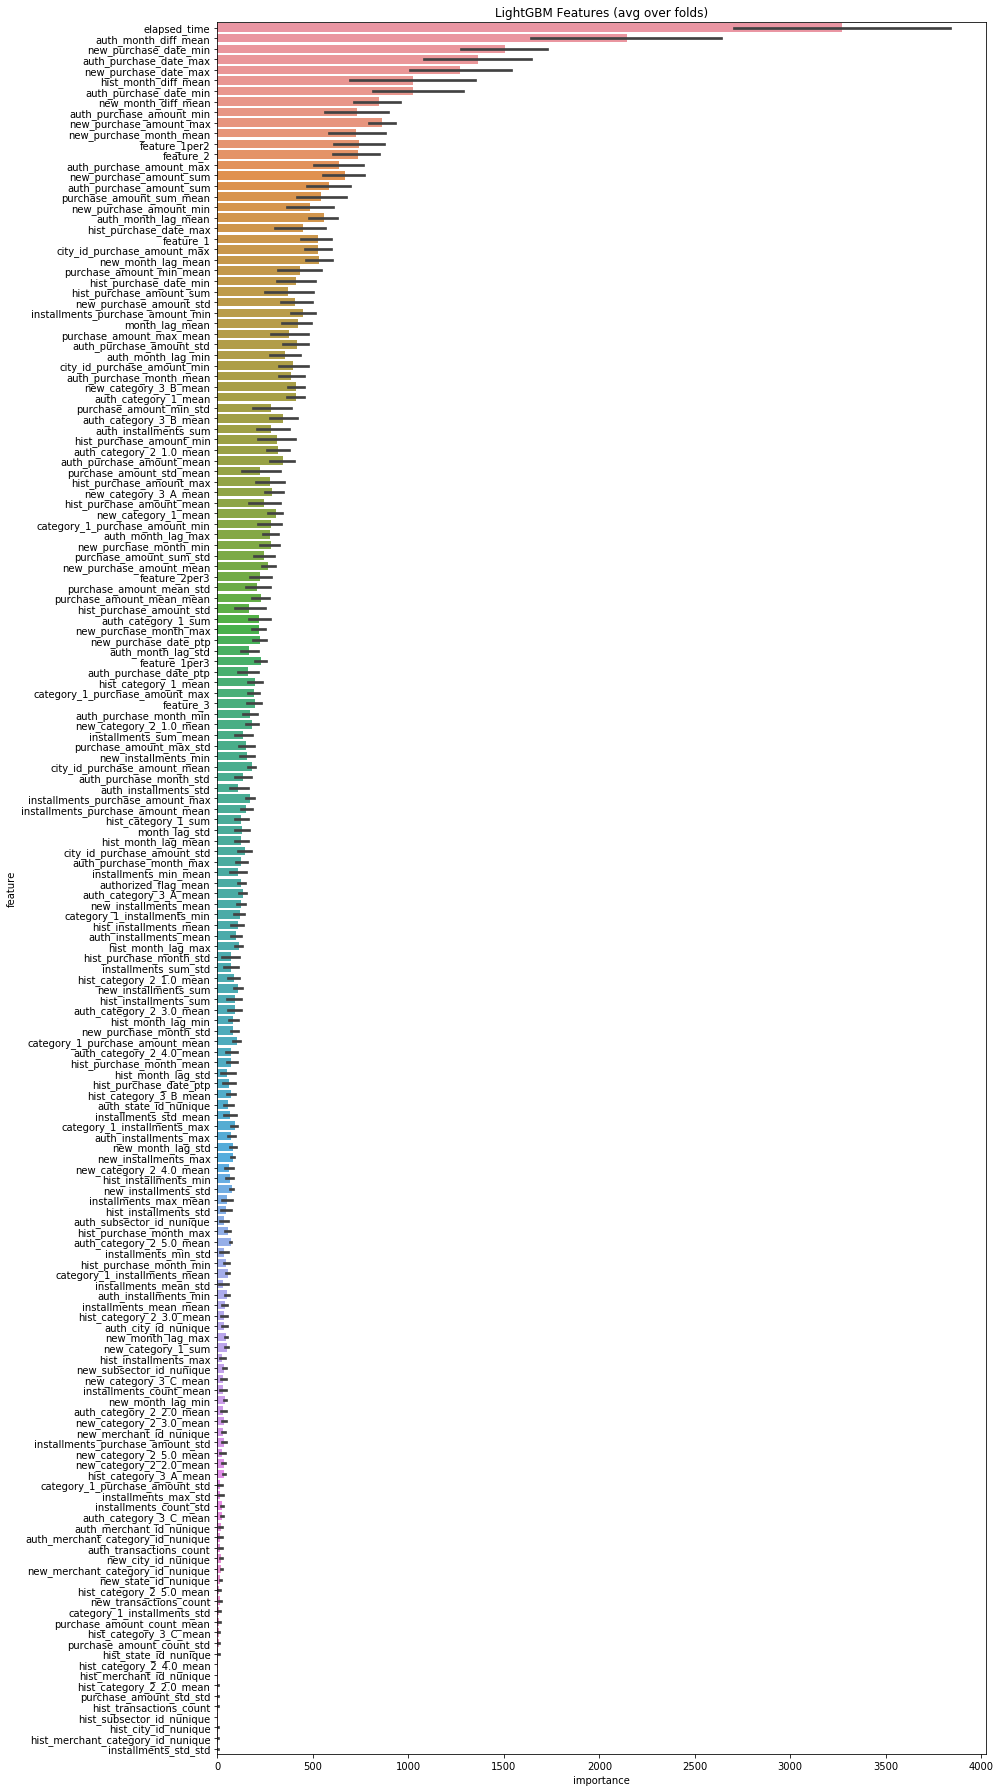

In [80]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [31]:
feature_importance_df.head()

,feature,importance,fold
0,feature_1,1293,1
1,feature_2,1524,1
2,feature_3,517,1
3,elapsed_time,5164,1
4,hist_transactions_count,0,1


In [30]:
fold_importance_df.head()

,feature,importance,fold
0,feature_1,896,5
1,feature_2,894,5
2,feature_3,312,5
3,elapsed_time,3127,5
4,hist_transactions_count,1,5


In [60]:
features = feature_importance_df[:100]['feature']

In [117]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.81827	valid_1's rmse: 3.8624
[200]	training's rmse: 3.80651	valid_1's rmse: 3.85349
[300]	training's rmse: 3.79918	valid_1's rmse: 3.84902
[400]	training's rmse: 3.79433	valid_1's rmse: 3.84681
[500]	training's rmse: 3.79086	valid_1's rmse: 3.84551
[600]	training's rmse: 3.78837	valid_1's rmse: 3.84497
[700]	training's rmse: 3.78622	valid_1's rmse: 3.8446
[800]	training's rmse: 3.78437	valid_1's rmse: 3.84443
[900]	training's rmse: 3.7826	valid_1's rmse: 3.84421
[1000]	training's rmse: 3.78102	valid_1's rmse: 3.8441
[1100]	training's rmse: 3.77943	valid_1's rmse: 3.84406
[1200]	training's rmse: 3.77798	valid_1's rmse: 3.84397
[1300]	training's rmse: 3.77647	valid_1's rmse: 3.84395
[1400]	training's rmse: 3.77508	valid_1's rmse: 3.84389
[1500]	training's rmse: 3.7738	valid_1's rmse: 3.84392
[1600]	training's rmse: 3.77252	valid_1's rmse: 3.84396
Early stopping, best iteration is:
[1403]	trai

In [81]:
for col in train.columns:
    print(col)

first_active_month
card_id
feature_1
feature_2
feature_3
elapsed_time
hist_transactions_count
hist_city_id_nunique
hist_month_lag_mean
hist_month_lag_max
hist_month_lag_min
hist_month_lag_std
hist_installments_sum
hist_installments_mean
hist_installments_max
hist_installments_min
hist_installments_std
hist_category_2_4.0_mean
hist_purchase_month_mean
hist_purchase_month_max
hist_purchase_month_min
hist_purchase_month_std
hist_merchant_id_nunique
hist_merchant_category_id_nunique
hist_purchase_amount_sum
hist_purchase_amount_mean
hist_purchase_amount_max
hist_purchase_amount_min
hist_purchase_amount_std
hist_month_diff_mean
hist_category_2_1.0_mean
hist_category_2_2.0_mean
hist_category_3_A_mean
hist_state_id_nunique
hist_category_2_3.0_mean
hist_subsector_id_nunique
hist_category_3_C_mean
hist_purchase_date_ptp
hist_purchase_date_min
hist_purchase_date_max
hist_category_2_5.0_mean
hist_category_1_sum
hist_category_1_mean
hist_category_3_B_mean
auth_transactions_count
auth_city_id_nuniq

In [153]:
# train and predict without Kfold

X_train, X_test, y_train, y_test = train_test_split(train[features], target, test_size=0.3)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

num_round = 10000
clf = lgb.train(param,
                lgb_train,
                num_round,
                valid_sets = lgb_eval,
                verbose_eval=100,
                early_stopping_rounds = 200)

predictions = clf.predict(X_test[features])
print("RMSE : {:<8.5f}".format(mean_squared_error(predictions, y_test)**0.5))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 3.87723
[200]	valid_0's rmse: 3.86273
[300]	valid_0's rmse: 3.8561
[400]	valid_0's rmse: 3.85321
[500]	valid_0's rmse: 3.85195
[600]	valid_0's rmse: 3.85125
[700]	valid_0's rmse: 3.85119
[800]	valid_0's rmse: 3.85119
[900]	valid_0's rmse: 3.85125
Early stopping, best iteration is:
[719]	valid_0's rmse: 3.85114
RMSE : 3.85114 


In [106]:
for i in range(6):
    train = read_data('input/original/train.csv')
    test = read_data('input/original/test.csv')

    target = train['target']
    del train['target']

    if i != 0:
        train = pd.merge(train, history, on='card_id', how='left')
        test = pd.merge(test, history, on='card_id', how='left')

    if i != 1:
        train = pd.merge(train, authorized, on='card_id', how='left')
        test = pd.merge(test, authorized, on='card_id', how='left')
        
    if i != 2:
        train = pd.merge(train, new, on='card_id', how='left')
        test = pd.merge(test, new, on='card_id', how='left')

    if i != 3:
        train = pd.merge(train, final_group, on='card_id', how='left')
        test = pd.merge(test, final_group, on='card_id', how='left')

    if i != 4:
        train = pd.merge(train, auth_mean, on='card_id', how='left')
        test = pd.merge(test, auth_mean, on='card_id', how='left')

    if i != 5:
        train = pd.merge(train, additional_fields, on='card_id', how='left')
        test = pd.merge(test, additional_fields, on='card_id', how='left')
    
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
    X_train, X_test, y_train, y_test = train_test_split(train[features], target, test_size=0.3)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    num_round = 1000
    clf = lgb.train(param,
                    lgb_train,
                    num_round,
                    valid_sets = lgb_eval,
                    verbose_eval=100,
                    early_stopping_rounds = 200)

    predictions = clf.predict(X_test[features])
    print("RMSE : {:<8.5f}".format(mean_squared_error(predictions, y_test)**0.5))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 3.83986
[200]	valid_0's rmse: 3.82506
[300]	valid_0's rmse: 3.81861
[400]	valid_0's rmse: 3.81525
[500]	valid_0's rmse: 3.81346
[600]	valid_0's rmse: 3.81257
[700]	valid_0's rmse: 3.81203
[800]	valid_0's rmse: 3.81177
[900]	valid_0's rmse: 3.81155
[1000]	valid_0's rmse: 3.8115
Did not meet early stopping. Best iteration is:
[942]	valid_0's rmse: 3.81147
RMSE : 3.81147 
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 3.86467
[200]	valid_0's rmse: 3.85443
[300]	valid_0's rmse: 3.84962
[400]	valid_0's rmse: 3.84706
[500]	valid_0's rmse: 3.84576
[600]	valid_0's rmse: 3.84499
[700]	valid_0's rmse: 3.84449
[800]	valid_0's rmse: 3.84416
[900]	valid_0's rmse: 3.84389
[1000]	valid_0's rmse: 3.84373
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 3.84372
RMSE : 3.84372 
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 

In [98]:
[i for i in range(3)]

[0, 1, 2]

In [103]:
train = read_data('input/original/train.csv')
test = read_data('input/original/test.csv')
target = train['target']
del train['target']

In [104]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92
